<a href="https://colab.research.google.com/github/Msaleemakhtar/Deep-Learning-with-pytorch/blob/main/04_classificationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with pyTorch

# ***1.Binary Classification ***

In [278]:
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples=n_samples, noise=0.03, random_state=55)

In [279]:
X.shape, y.shape

((1000, 2), (1000,))

In [280]:
X[0:5], y[0:5]

(array([[ 0.84185974, -0.50240901],
        [ 0.11561202, -0.967942  ],
        [ 0.71458802,  0.27456366],
        [ 0.19204725, -0.77725032],
        [-0.96940563,  0.14870034]]),
 array([0, 0, 1, 1, 0]))

In [281]:
import pandas as pd
circle = pd.DataFrame({"X1": X[:,0], "X2":X[:,1], "label":y})

In [282]:
circle.head()

,X1,X2,label
0,0.841860,-0.502409,0
1,0.115612,-0.967942,0
2,0.714588,0.274564,1
3,0.192047,-0.777250,1
4,-0.969406,0.148700,0


In [283]:
circle.X1.value_counts()

X1
 0.841860    1
-0.977034    1
 0.406836    1
-0.927229    1
-0.151870    1
            ..
 0.743345    1
-0.752254    1
-0.975437    1
-0.103319    1
 0.901243    1
Name: count, Length: 1000, dtype: int64

In [284]:
circle.label.value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [285]:
y.shape

(1000,)

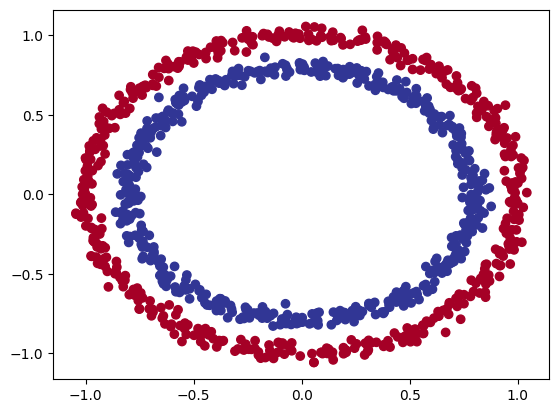

In [286]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
           y =X[:,1],
           c=y,
           cmap= plt.cm.RdYlBu)

In [287]:
import torch


In [288]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.8419, -0.5024],
         [ 0.1156, -0.9679],
         [ 0.7146,  0.2746],
         [ 0.1920, -0.7773],
         [-0.9694,  0.1487]]),
 tensor([0., 0., 1., 1., 0.]))

In [289]:
# split the data for model traing and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=33)

In [290]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [291]:
# device agnostic code
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [309]:
# Building Model
class Model_for_classification(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu =  nn.ReLU()

  def forward(self, x:torch.Tensor)->torch.Tensor:

    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0 = Model_for_classification().to(device)
print(model_0)

Model_for_classification(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [310]:
# replicate Model_for_classification with nn.sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features =2, out_features= 5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

In [311]:
# make predictions with the model
untrained_pred = model_0(X_test.to(device))
print(f"untrained_pred: {len(untrained_pred)}, shape: {untrained_pred.shape}")
print(f"sample test: {len(y_test)}, shape : {y_test.shape}")
untrained_pred[:5], y_test[:5]

untrained_pred: 200, shape: torch.Size([200, 1])
sample test: 200, shape : torch.Size([200])


(tensor([[0.0095],
         [0.0566],
         [0.0205],
         [0.0077],
         [0.0079]], grad_fn=<SliceBackward0>),
 tensor([0., 0., 0., 0., 1.]))

In [312]:
# set up the loss function

loss_fn = nn.BCEWithLogitsLoss() # with sigmoid built_in

# optimizor
optimizor = torch.optim.SGD(params=model_0.parameters(), lr= 0.1)

In [313]:
# setup the evaluation metrics
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/(len(y_true)) *100
  return acc



In [314]:
# Raw model output to predicted labels(logits -> pred probability-> prediction labels)
logits = model_0(X_test.to(device))
logits[:5]

tensor([[0.0095],
        [0.0566],
        [0.0205],
        [0.0077],
        [0.0079]], grad_fn=<SliceBackward0>)

In [315]:
y_pred_probs = torch.sigmoid(logits)
y_pred_probs[:5]

tensor([[0.5024],
        [0.5141],
        [0.5051],
        [0.5019],
        [0.5020]], grad_fn=<SliceBackward0>)

In [316]:
# if the y_pred>= 0.5 = 1 class , if y_pred<=0.5 = close to 0 class
# lets round the y_pred
y_preds= torch.round(y_pred_probs)


In [323]:
# Train and Evaluate the model
torch.manual_seed(55)
 # put the data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


epochs = 1000
for epoch in range(epochs):
  # training
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  # loss function
  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # optimizor for zero grad
  optimizor.zero_grad()
  # back propogation
  loss.backward()
  # optimizor step
  optimizor.step()

  # model testing
  model_0.eval() # put the model under testing
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # set loss function
    test_loss = loss_fn(test_logits, y_test)
    # calculate accuracy
    test_accuracy = accuracy_fn(y_true=y_test, y_pred = test_preds)
  if epoch % 100 == 0:
    print(f"epoch: {epoch}  | loss: {loss}, accuracy: {accuracy}    | test_loss : {test_loss}, test_accuracy:{test_accuracy}")





epoch: 0  | loss: 0.4900580942630768, accuracy: 90.875    | test_loss : 0.5023866295814514, test_accuracy:89.0
epoch: 100  | loss: 0.3791694641113281, accuracy: 97.0    | test_loss : 0.3921627104282379, test_accuracy:95.5
epoch: 200  | loss: 0.2652771472930908, accuracy: 99.375    | test_loss : 0.27774497866630554, test_accuracy:98.5
epoch: 300  | loss: 0.17758974432945251, accuracy: 99.875    | test_loss : 0.19179099798202515, test_accuracy:99.0
epoch: 400  | loss: 0.12470889836549759, accuracy: 99.625    | test_loss : 0.14078111946582794, test_accuracy:99.0
epoch: 500  | loss: 0.09255457669496536, accuracy: 99.75    | test_loss : 0.10724377632141113, test_accuracy:99.0
epoch: 600  | loss: 0.07259340584278107, accuracy: 99.75    | test_loss : 0.08625663816928864, test_accuracy:99.5
epoch: 700  | loss: 0.059028249233961105, accuracy: 99.75    | test_loss : 0.07105980813503265, test_accuracy:99.5
epoch: 800  | loss: 0.04964946582913399, accuracy: 99.75    | test_loss : 0.060523081570863

In [324]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [325]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


In [326]:
# Visualize the data
from pathlib import Path
import requests

if Path("helper_functions.py").is_file():
  print("File is already available")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

File is already available


In [327]:
import numpy as np
import matplotlib.pyplot as plt


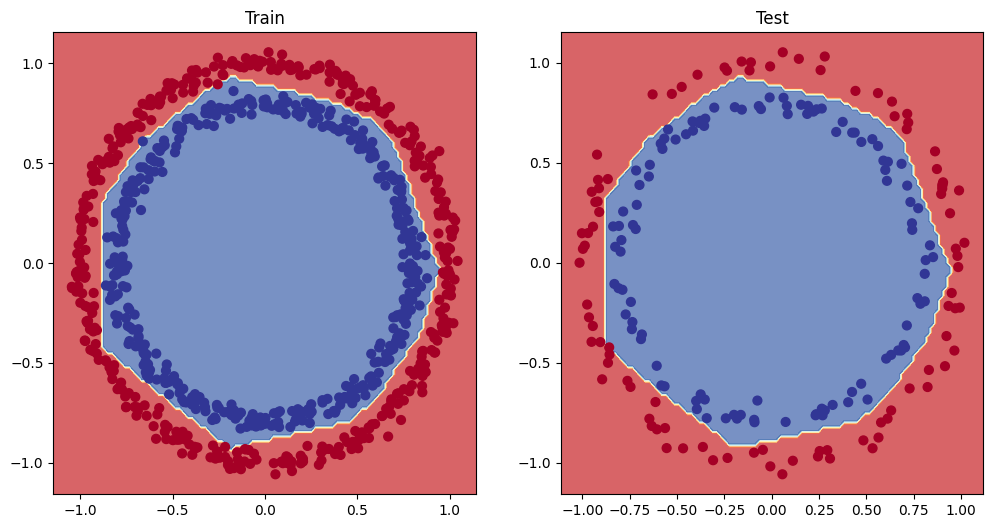

In [328]:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)



# **2. Mult_class classificati**on